# Introducción

La clasificación automática es una herramienta muy importante en la actualidad debido a la gran cantidad de información de la que disponemos, ya que nos permite utilizar algoritmos computacionales y técnicas de aprendizaje automático para categorizar datos en un conjunto de etiquetas definidas sin necesidad de intervención humana. La finalidad es asignar a los datos las categorías correctas de forma exacta y eficiente. Esto tiene bastantes aplicaciones en campos muy diversos, como detección de enfermedades a partir de imágenes de pacientes, clasificación de productos en un comercio electrónico, control de calidad, entre otros. Asimismo, esto es aplicable para textos, por ejemplo en sistemas de reconocimiento de spam, clasificación de documentos, etc.

Debido a esto, surge la necesidad de crear metodologías que permitan evaluar las predicciones de un algoritmo de clasificación. 

El objetivo de este trabajo es realizar la evaluación, mediante métricas como exactitud, precisión, recall y $F_{1}$ de algoritmos de clasificación, en particular Support Vector Machine (SVM) y Naive Bayes (NB) y comparar los resultados obtenidos usando distintas representaciones vectoriales.

# Desarrollo

## Descripción de los conjuntos de datos

Para la realización de este trabajo se usaron dos conjuntos. A continuación se describe cada uno:

### Conjunto de datos cellphones

Este  conjunto de datos está conformado por tweets sobre celulares, incluyendo algunas marcas en específico. El objetivo de los datos en este conjunto es detectar la polaridad acerca del tema. Los elementos del conjunto de datos están formados por categoría, identificador, clase, texto y tipo.

El campo clase (klass) tiene los valores posibles information, positive, negative y neutral. Estas etiquetas fueron asignadas de forma manual por personas y se asumen como verdaderas. 

En este caso, nos concentramos en los campos texto y clase para realizar el entrenamiento de los algoritmos de clasificación.

A continuación se muestra un ejemplo de un tweet de este conjunto:

> {"categories": "[ \"DEVICE\", \"OS\" ]", "id": "d0fb202ea47c3cad448ea4e5e31bd404", "klass": "information", "text": "RT @matukpuntocom: Xperia Play se quedar\u00e1 sin Android 4.0 http://t.co/463lAcCp", "type": "Xperia"}

Se usarán 2 conjuntos: conjunto de entrenamiento y conjunto de prueba.

En las siguientes tablas se encuentran las distribuciones de las clases para los conjuntos de entrenamiento y prueba, respectivamente:

| Information      | Negative | Neutral    | Positive     |
| :---        |    :----:   |          ---: |         ---: |
| 7516      | 860       | 1856   | 1212    |

| Information      | Negative | Neutral    | Positive     |
| :---        |    :----:   |          ---: |         ---: |
| 3222      | 368       | 796   | 519    |

### Conjunto de datos aggresiveness

Este  conjunto de datos está conformado por tweets que pueden contener o no comentarios agresivos. El objetivo de los datos en este conjunto es detectar si existe agresividad en el texto. Los elementos del conjunto de datos están formados por identificador, clase, texto.

El campo clase (klass) tiene dos valores posibles positivo o negativo. Estas etiquetas fueron asignadas de forma manual por personas y se asumen como verdaderas. 

En este caso, también nos concentramos en los campos texto y clase para realizar el entrenamiento de los algoritmos de clasificación.

A continuación se muestra un ejemplo de un tweet de este conjunto:

> {"id": 2283, "klass": 1, "text": "de verdad que chinguen a su madre todos hoy me cae\n"}

Se usarán 2 conjuntos: conjunto de entrenamiento y conjunto de prueba.

En las siguientes tablas se encuentran las distribuciones de las clases para los conjuntos de entrenamiento y prueba, respectivamente:

| Negativo      | Positivo | 
| :---        |    :----:   | 
| 3655      | 1477       | 

| Negativo      | Positivo | 
| :---        |    :----:   | 
| 1565      | 631       | 

## Implementación

La implementación de esta solución se utilizó Python. A continuación se muestra el código para los puntos más importantes.

### Preprocesamiento

In [5]:
PUNCTUACTION = ";:,.\\-\"'/"
SYMBOLS = "()[]¿?¡!{}~<>|"
SKIP_SYMBOLS = set(PUNCTUACTION + SYMBOLS)
SKIP_SYMBOLS_AND_SPACES = set(PUNCTUACTION + SYMBOLS + '\t\n\r ')

def normalize_text(input_str,
                   punct=False,
                   accents=False,
                   max_dup=2):
    nfkd_f = unicodedata.normalize('NFKD', input_str)
    n_str = []
    c_prev = ''
    cc_prev = 0
    for c in nfkd_f:
        if not punct:
            if c in SKIP_SYMBOLS:
                continue
        if not accents and unicodedata.combining(c):
            continue
        if c_prev == c:
            cc_prev += 1
            if cc_prev >= max_dup:
                continue
        else:
            cc_prev = 0
        n_str.append(c)
        c_prev = c
    return "".join(n_str)

La función anterior se utiliza para preprocesar el texto. Permite remover acentos, signos de puntuación, y limitar la cantidad de caracteres duplicados consecutivos. Recibe como parámetro el texto que se desee preprocesar. También tiene parámetros que permiten conservar la puntuación, acentos (falsos por defecto )y el numero de caracteres duplicados (2, por defecto). 

### Lectura de datos

In [7]:
def line_iterator(filename):
    if filename.endswith(".gz"):
        f = gzip.GzipFile(filename)
    else:
        f = open(filename, encoding='utf8')

    while True:
        line = f.readline()
        # Test the type of the line and encode it if neccesary...
        if type(line) is bytes:
            line = str(line, encoding='utf8')

        # If the line is empty, we are done...
        if len(line) == 0:
            break

        line = line.strip()
        # If line is empty, jump to next...
        if len(line) == 0:
            continue

        yield line

    # Close the file...
    f.close()

def tweet_iterator(filename):
    for line in line_iterator(filename):
        yield json.loads(line)

Las funciones anteriores nos ayudan a leer y procesar los tweets del conjunto de datos, a partir de un archivo de texto usando un enfoque basado en iteradores. Finalmente, devuelven un objeto JSON que nos permite realizar operaciones con él. Recibe como parámetro el nombre del archivo a utilizar.

### Carga del conjunto de datos

Esta función nos permite obtener el texto preprocesado y las clases asociadas a cada tweet en el conjunto de datos. Recibe como parámetro el nombre del archivo del conjunto de datos.

In [9]:
def load_corpus(file):
    X=[]
    Y=[]    
    for review in tweet_iterator(file):
        text = normalize_text(review['text'])
        X.append(text.lower())
        Y.append(review['klass'])        
    return X,Y

### Vectorización de los datos

Para poder entrenar los algoritmos de clasificación, se debe transformar el texto a una representación numérica. En este caso, se eligieron 2 transformaciones: frecuencia de términos (TF) y  frecuencia de término – frecuencia inversa de documento (TF-IDF). A continuación se muestra el código:

Primero se cargan los conjuntos de datos para cellphones: el conjunto formado por el archivo cellphones_train.json servirá como conjunto de entrenamiento y cellphones_test.json como conjunto de prueba. Para el conjunto de datos de agresividad, el archivo AgresivenessDetection_train.json servirá como conjunto de entrenamiento y AgresivenessDetection_train.json como conjunto de prueba  En todos los casos, se excluyen las stop-words.

In [ ]:
X_cell_train, Y_cell_train = load_corpus("cellphones_train.json")
X_cell_test, Y_cell_test = load_corpus("cellphones_test.json")

In [ ]:
X_aggr_train, Y_aggr_train = load_corpus("AggressivenessDetection_train.json")
X_aggr_test, Y_aggr_test = load_corpus("AggressivenessDetection_test.json")

Posteriormente, usamos CountVectorizer para obtener la representación vectorial usando la frecuencia de términos, para los textos de los tweets de los conjuntos de entrenamiento:

In [ ]:
vectorizer_cell = CountVectorizer(stop_words=stopwords.words('spanish'))  
X_vec_cell_tf = vectorizer_cell.fit_transform(X_cell_train)

In [ ]:
tfidfvec_cell = TfidfVectorizer(stop_words=stopwords.words('spanish'))  
X_vec_cell_tf_idf = tfidfvec_cell.fit_transform(X_cell_train)

De forma análoga, obtenemos la representación usando TF-IDF:

In [ ]:
vectorizer_aggr = CountVectorizer(stop_words=stopwords.words('spanish'))  
X_vec_aggr_tf = vectorizer_aggr.fit_transform(X_aggr_train)

In [ ]:
tfidfvec_aggr = TfidfVectorizer(stop_words=stopwords.words('spanish'))  
X_vec_aggr_tf_idf = tfidfvec_aggr.fit_transform(X_aggr_train)

### Entrenamiento de los algoritmos de clasificación

Para la clasificación se eligieron 2 algoritmos: Naive Bayes (NB) y Support Vector Machine (SVM). Para cada algoritmo se usarán las 2 representaciones TF y TF-IDF y se entrenarán para cada conjunto:

Primero, se entrenan los clasificadores Naive Bayes:

Entrenando Naive Bayes con TF para el conjunto de datos cellphone:

In [ ]:
mnb_cell_tf = MultinomialNB()
mnb_cell_tf.fit(X_vec_cell_tf, Y_cell_train)

Entrenando Naive Bayes con TF-IDF para el conjunto de datos cellphone:

In [ ]:
mnb_cell_tfidf = MultinomialNB()
mnb_cell_tfidf.fit(X_vec_cell_tf_idf, Y_cell_train)

Entrenando Naive Bayes con TF para el conjunto de datos de agresividad:

In [ ]:
mnb_aggr_tf = MultinomialNB()
mnb_aggr_tf.fit(X_vec_aggr_tf, Y_aggr_train)

Entrenando Naive Bayes con TF-IDF para el conjunto de datos de agresividad:

In [ ]:
mnb_aggr_tfidf = MultinomialNB()
mnb_aggr_tfidf.fit(X_vec_aggr_tf_idf, Y_aggr_train)

Posteriormente, se entrenan los clasificadores SMV:

Entrenando SVM con TF para el conjunto de datos cellphone:

In [ ]:
svc_cell_tf = LinearSVC(random_state=0, max_iter=3000)
svc_cell_tf.fit(X_vec_cell_tf, Y_cell_train)

Entrenando SVM con TF-IDF para el conjunto de datos cellphone:

In [ ]:
svc_cell_tfidf = LinearSVC(random_state=0, max_iter=3000)
svc_cell_tfidf.fit(X_vec_cell_tf_idf, Y_cell_train)

Entrenando SVM con TF para el conjunto de datos de agresividad:

In [ ]:
svc_aggr_tf = LinearSVC(random_state=0, max_iter=3000)
svc_aggr_tf.fit(X_vec_aggr_tf, Y_aggr_train)

Entrenando SVM con TF-IDF para el conjunto de datos de agresividad:

In [ ]:
svc_aggr_tfidf = LinearSVC(random_state=0, max_iter=3000)
svc_aggr_tfidf.fit(X_vec_aggr_tf_idf, Y_aggr_train)

### Predicciones

Si se desea realizar predicciones debemos vectorizar los datos de prueba usando TF y TF-IDF y posteriormente usar el modelo correspondiente. A continuación se muestra el código para realizar lo descrito:

Primero se vectorizan los datos de cellphones:

In [ ]:
#Vectorizando datasets de prueba cellphones
X_test_cell_vec_tf_idf = tfidfvec_cell.transform(X_cell_test)
X_test_cell_vec_tf = vectorizer_cell.transform(X_cell_test)

Luego, se vectorizan los de agresividad:

In [ ]:
X_test_aggr_vec_tf_idf = tfidfvec_aggr.transform(X_aggr_test)
X_test_aggr_vec_tf = vectorizer_aggr.transform(X_aggr_test)

Prediciendo datos con NB y TF para el conjunto de prueba cellphones:

In [ ]:
y_mnb_cell_test_predict_tf = mnb_cell_tf.predict(X_test_cell_vec_tf)

Prediciendo datos con NB y TF-IDF para el conjunto de prueba cellphones:

In [ ]:
y_mnb_cell_test_predict_tfidf = mnb_cell_tfidf.predict(X_test_cell_vec_tf_idf)

Prediciendo datos con NB y TF para el conjunto de prueba de agresividad:

In [ ]:
y_mnb_aggr_test_predict_tf = mnb_aggr_tf.predict(X_test_aggr_vec_tf)

Prediciendo datos con NB y TF-IDF para el conjunto de prueba de agresividad:

In [ ]:
y_mnb_aggr_test_predict_tfidf = mnb_aggr_tfidf.predict(X_test_aggr_vec_tf_idf)

Prediciendo datos con SVM y TF para el conjunto de prueba cellphones:

In [ ]:
y_svm_cell_test_predict_tf = svc_cell_tf.predict(X_test_cell_vec_tf)

Prediciendo datos con SVM y TF-IDF para el conjunto de prueba cellphones:

In [ ]:
y_svm_cell_test_predict_tfidf = svc_cell_tfidf.predict(X_test_cell_vec_tf_idf)

Prediciendo datos con SVM y TF para el conjunto de prueba de agresividad:

In [ ]:
y_svm_aggr_test_predict_tf = svc_aggr_tf.predict(X_test_aggr_vec_tf)

Prediciendo datos con SVM y TF-IDF para el conjunto de prueba de agresividad:

In [ ]:
y_svm_aggr_test_predict_tfidf = svc_aggr_tfidf.predict(X_test_aggr_vec_tf_idf)

### Evaluación del desempeño

#### Métricas de evaluación

Para la evaluación del desempeño de los modelos entrenados, se usan las métricas de exactitud, precisión, recall y $F_1$, macro y micro. A continuación se muestran las definiciones de cada una de éstas:

* __Exactitud (accuracy)__ :
Es el número de ejemplos positivos clasificados correctamente dividido por
el número de ejemplos etiquetados por el sistema como positivos:

    $\text{Exactitud} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}$

* __Precisión__: Es el número de ejemplos positivos clasificados correctamente dividido por
el número de ejemplos positivos en los datos.

    $\text{Precision}_{\text{micro}} = \frac{\sum_{i=1}^{C} \text{TP}_i}{\sum_{i=1}^{C} (\text{TP}_i + \text{FP}_i)}$
    
    $\text{Precision}_{\text{macro}} = \frac{1}{C} \sum_{i=1}^{C} \frac{\text{TP}_i}{\text{TP}_i + \text{FP}_i}$
    

* __Recall__: Es el número de ejemplos positivos clasificados correctamente dividido por
el número de ejemplos positivos en los datos

    $\text{Recall}_{\text{micro}} = \frac{\sum_{i=1}^{C} \text{TP}_i}{\sum_{i=1}^{C} (\text{TP}_i + \text{FN}_i)}$

    $\text{Recall}_{\text{macro}} = \frac{1}{C} \sum_{i=1}^{C} \frac{\text{TP}_i}{\text{TP}_i + \text{FN}_i}$

* __$F_{1}$__: Es la media harmónica de la precisión y recall

    $\text{F1}_{\text{micro}} = \frac{2 \times \sum_{i=1}^{C} \text{TP}_i}{2 \times \sum_{i=1}^{C} \text{TP}_i + \sum_{i=1}^{C} (\text{FP}_i + \text{FN}_i)}$

    $\text{F1}_{\text{macro}} = \frac{1}{C} \sum_{i=1}^{C} \frac{2 \times \text{TP}_i}{2 \times \text{TP}_i + \text{FP}_i + \text{FN}_i}$

Donde TP (True Positive) son los ejemplos clasificados como positivos correctamente, TN (True Negative) son los ejemplos clasificados como negativos correctamente, FN (False Negative) son los ejemplos clasificados como negativos incorrectamente y FP (False Positive) son los ejemplos clasificados como positivos incorrectamente.

La función siguiente nos permite medir el desempeño del modelo entrenado usando las métricas anteriormente descritas. Recibe como parámetros las clases reales y las predecidas.

In [19]:
def print_scores(true_labels, predicted_labels):
    print("Accuracy = ", accuracy_score(true_labels, predicted_labels))
    print("Recall macro  =", recall_score(true_labels, predicted_labels, average='macro'))
    print("Precision macro =", precision_score(true_labels, predicted_labels, average='macro'))
    print("F1 macro =", f1_score(true_labels, predicted_labels, average='macro'))
    print("Recall micro  =", recall_score(true_labels, predicted_labels, average='micro'))
    print("Precision micro =", precision_score(true_labels, predicted_labels, average='micro'))
    print("F1 micro =", f1_score(true_labels, predicted_labels, average='micro'))

#### Matriz de confusión

Por otra parte, también se usa la matriz de confusión, que nos permite representar el cálculo de los
ejemplos de las clases reconocidos correctamente (true positive), el número
de ejemplos reconocidos correctamente que no pertenecen a la clase (true
negative), los ejemplos que fueron asignados incorrectamente a la clase
(false positive), o los ejemplos que no fueron reconocidos como ejemplos de
la clase (false negative).

Mediante la siguiente función, obtenemos la matriz de confusión. Recibe como parámetro un arreglo de las etiquetas reales, un arreglo de predicciones y un arreglo del nombre de las etiquetas. 

In [ ]:
def get_confusion_matrix(true_labels, predicted_labels, labels):
    return confusion_matrix(true_labels, predicted_labels, labels = labels)

### Visualización de los resultados

#### Comparación de métricas

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def plot_data(categories, group_names, values, title):
    fig, ax = plt.subplots()
  
    bar_height = 0.15
    bar_spacing = 0.1
  
    bar_positions = np.arange(len(categories)) * (len(group_names) * bar_height + bar_spacing)

   
    for i, group_name in enumerate(group_names):
        bars = ax.barh(bar_positions + i * bar_height, values[i], bar_height, label=group_name)
  
    ax.set_xlabel('Valor métricas')
    ax.set_ylabel('Métricas')
    ax.set_title(title)
    ax.set_yticks(bar_positions + ((len(group_names) - 1) * bar_height + bar_spacing) / 2)
    ax.set_yticklabels(categories)
    
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    fig.subplots_adjust(right=0.75)  # Adjust the value based on your plot

    plt.show()

Esta función nos permite comparar las predicciones obtenidas para cada algoritmo ( por cada conjunto de datos) de aprendizaje automático mediante una gráfica de barras. El primer parámetro es un arreglo de etiquetas del eje y, el segundo es un arreglo de etiquetas de cada algoritmo, el tercero son los valores de las métricas para cada algoritmo, y el título del gráfico.

## Resultados

### Desempeño de los clasificadores

Evaluamos las predicciones obtenidas por cada uno de los algoritmos para su conjunto de prueba respectivo, usando la función print_scores. Se evalúan usando las métricas exactitud, precisión, recall, $F_1$ (tanto micro como macro) y obtenemos la siguiente información:

#### Conjunto cellphones

 Primero evaluamos las predicciones para el conjunto cellphones. Los resultados se muestran en la siguiente tabla:

| Algoritmo   | Exactitud | Recall macro  |  Precisión macro | $F_{1}$ macro |Recall micro | Precision micro | $F_{1}$ micro |
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
| Naive Bayes TF      | 0.734352       | 0.43924     |  0.71194       |  0.487520      | 0.734352     | 0.7343527      |  0.734352  |
| Naive Bayes TF-IDF   | 0.70866       | 0.34762      | 0.90364       |0.37022       | 0.70866      | 0.70866       | 0.70866       |
| SVM TF      | 0.7296       | 0.56490      |  0.59056       | 0.57663       | 0.72966     | 0.72966       | 0.72966       |
| SVM TF-IDF   | 0.74760        | 0.56003      | 0.62301       |0.58622       | 0.74760      | 0.74760      | 0.74760       |

De acuerdo a los datos anteriores, podemos ver que SVM TF-IDF es el modelo con mayor exactitud, pero en cuestión de precisión macro Naive Bayes TF es superior con 90.36% comparado con 62.3%. A pesar de esto, este modelo tiene la peor puntuación de $F_{1}$ macro. En cuestión de recall, precisión y $F_{1} $ micro, las puntuaciones son las mismas para las 3 métricas en cada modelo y son iguales que la exactitud correspondiente. Esto se debe a que en tareas de clasificación donde se garantiza que cada instancia  sea asignada a exactamente una clase, calcular un métrica micro es equivalente a calcular precisión

In [6]:
from IPython.display import display, HTML

A continuación se muestra la matriz de confusión obtenida para las predicciones realizadas con Naive Bayes y TF:

In [15]:
display(HTML('<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>information</th>\n      <th>negative</th>\n      <th>neutral</th>\n      <th>positive</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>information</th>\n      <td>3101</td>\n      <td>13</td>\n      <td>87</td>\n      <td>21</td>\n    </tr>\n    <tr>\n      <th>negative</th>\n      <td>260</td>\n      <td>52</td>\n      <td>48</td>\n      <td>8</td>\n    </tr>\n    <tr>\n      <th>neutral</th>\n      <td>458</td>\n      <td>6</td>\n      <td>316</td>\n      <td>16</td>\n    </tr>\n    <tr>\n      <th>positive</th>\n      <td>351</td>\n      <td>3</td>\n      <td>32</td>\n      <td>133</td>\n    </tr>\n  </tbody>\n</table>'))

,information,negative,neutral,positive
information,3101,13,87,21
negative,260,52,48,8
neutral,458,6,316,16
positive,351,3,32,133


Se observa que en la mayoría de los casos, las instancias fueron asignadas a la clase mayoritaria. Es decir, se clasificaron incorrectamente instancias negativas, neutrales y positivas como de clase información.

A continuación se muestra la matriz de confusión obtenida para las predicciones realizadas con Naive Bayes y TF-IDF:

In [16]:
display(HTML('<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>information</th>\n      <th>negative</th>\n      <th>neutral</th>\n      <th>positive</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>information</th>\n      <td>3213</td>\n      <td>0</td>\n      <td>8</td>\n      <td>1</td>\n    </tr>\n    <tr>\n      <th>negative</th>\n      <td>355</td>\n      <td>10</td>\n      <td>2</td>\n      <td>1</td>\n    </tr>\n    <tr>\n      <th>neutral</th>\n      <td>615</td>\n      <td>0</td>\n      <td>181</td>\n      <td>0</td>\n    </tr>\n    <tr>\n      <th>positive</th>\n      <td>447</td>\n      <td>0</td>\n      <td>0</td>\n      <td>72</td>\n    </tr>\n  </tbody>\n</table>'))

,information,negative,neutral,positive
information,3213,0,8,1
negative,355,10,2,1
neutral,615,0,181,0
positive,447,0,0,72


En este caso, podemos ver que casi todas las instancias de information se clasificaron correctamente. Sin embargo, para las clases negative, neutral y positive, pocas instancias se asignaron a la clase verdadera mientras que la mayoría fueron asociadas a information. 

A continuación se muestra la matriz de confusión obtenida para las predicciones realizadas con SVM y TF:

In [17]:
display(HTML('<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>information</th>\n      <th>negative</th>\n      <th>neutral</th>\n      <th>positive</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>information</th>\n      <td>2780</td>\n      <td>117</td>\n      <td>203</td>\n      <td>122</td>\n    </tr>\n    <tr>\n      <th>negative</th>\n      <td>132</td>\n      <td>146</td>\n      <td>53</td>\n      <td>37</td>\n    </tr>\n    <tr>\n      <th>neutral</th>\n      <td>308</td>\n      <td>38</td>\n      <td>385</td>\n      <td>65</td>\n    </tr>\n    <tr>\n      <th>positive</th>\n      <td>159</td>\n      <td>20</td>\n      <td>72</td>\n      <td>268</td>\n    </tr>\n  </tbody>\n</table>'))

,information,negative,neutral,positive
information,2780,117,203,122
negative,132,146,53,37
neutral,308,38,385,65
positive,159,20,72,268


De acuerdo con la matriz, en este caso se asignó una mayor proporción de clases correctas en comparación con los modelos Naive Bayes. Sin embargo, también existe una cantidad considerable de cada clase asignada a la clase mayoritaria.

A continuación se muestra la matriz de confusión obtenida para las predicciones realizadas con SVM y TF-IDF:

In [18]:
display(HTML('<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>information</th>\n      <th>negative</th>\n      <th>neutral</th>\n      <th>positive</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>information</th>\n      <td>2892</td>\n      <td>83</td>\n      <td>155</td>\n      <td>92</td>\n    </tr>\n    <tr>\n      <th>negative</th>\n      <td>140</td>\n      <td>141</td>\n      <td>56</td>\n      <td>31</td>\n    </tr>\n    <tr>\n      <th>neutral</th>\n      <td>318</td>\n      <td>32</td>\n      <td>391</td>\n      <td>55</td>\n    </tr>\n    <tr>\n      <th>positive</th>\n      <td>188</td>\n      <td>17</td>\n      <td>71</td>\n      <td>243</td>\n    </tr>\n  </tbody>\n</table>'))

,information,negative,neutral,positive
information,2892,83,155,92
negative,140,141,56,31
neutral,318,32,391,55
positive,188,17,71,243


Con base en la matriz, se nota que la cantidad de verdaderos positivos aumentó comparada con el otro modelo de SVM con TF. Sin embargo, en la clase negativa la cantidad de instancias asociadas a la clase mayoritaria es casi igual que las asignadas a la clase verdadera. Para la clase positiva, disminuyeron los verdaderos positivos en comparación con el modelo anterior.

#### Conjunto de agresividad

Luego, evaluamos las predicciones para el conjunto de agresividad. Los resultados se muestran en la siguiente tabla:

| Algoritmo   | Exactitud | Recall macro  |  Precisión macro | $F_{1}$ macro |Recall micro | Precision micro | $F_{1}$ micro |
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
| Naive Bayes TF      | 0.81830       | 0.73490     | 0.79622       | 0.75488       | 0.81830     |0.81830       | 0.81830     |
| Naive Bayes TF-IDF   | 0.75455        |  0.57621     | 0.83970      |0.56059       | 0.75455      | 0.75455      | 0.75455       |
| SVM TF      |  0.81193     | 0.74982      | 0.77451     |0.76006       | 0.81193      | 0.81193       | 0.81193       |
| SVM TF-IDF   | 0.82468        | 0.76302      | 0.79266       |0.77511      | 0.82468      | 0.82468       | 0.82468       |

Con base en la tabla anterior, podemos ver que Naive Bayes con TF es el modelo de mayor exactitud. Sin embargo, en cuestión de precisión macro es superado por Naive Bayes con TF-IDF; para $F_{1}$ macro el modelo con la mejor puntuación es SVM con TF-IDF. En cuestión de recall, precisión y $F_{1}$ micro, podemos ver que los 3 valores son iguales entre sí e iguales a la exactitud.
También en este caso, las métricas macro tienen el mismo valor que la exactitud debido a lo explicado en el conjunto anterior.

Se muestra la matriz de confusión obtenida para las predicciones realizadas con Naive Bayes y TF:

In [19]:
display(HTML('<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>negativo</th>\n      <th>positivo</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>negativo</th>\n      <td>1457</td>\n      <td>108</td>\n    </tr>\n    <tr>\n      <th>positivo</th>\n      <td>291</td>\n      <td>340</td>\n    </tr>\n  </tbody>\n</table>'))

,negativo,positivo
negativo,1457,108
positivo,291,340


A continuación, se muestra la matriz de confusión obtenida para las predicciones realizadas con Naive Bayes y TF-IDF:

In [12]:
display(HTML('<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>negativo</th>\n      <th>positivo</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>negativo</th>\n      <td>1558</td>\n      <td>7</td>\n    </tr>\n    <tr>\n      <th>positivo</th>\n      <td>532</td>\n      <td>99</td>\n    </tr>\n  </tbody>\n</table>'))

,negativo,positivo
negativo,1558,7
positivo,532,99


Se muestra la matriz de confusión obtenida para las predicciones realizadas con SVM y TF:

In [13]:
display(HTML('<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>negativo</th>\n      <th>positivo</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>negativo</th>\n      <td>1402</td>\n      <td>163</td>\n    </tr>\n    <tr>\n      <th>positivo</th>\n      <td>250</td>\n      <td>381</td>\n    </tr>\n  </tbody>\n</table>'))

,negativo,positivo
negativo,1402,163
positivo,250,381


A continuación, se muestra la matriz de confusión obtenida para las predicciones realizadas con SVM y TF-IDF:

In [14]:
display(HTML('<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>negativo</th>\n      <th>positivo</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>negativo</th>\n      <td>1421</td>\n      <td>144</td>\n    </tr>\n    <tr>\n      <th>positivo</th>\n      <td>241</td>\n      <td>390</td>\n    </tr>\n  </tbody>\n</table>'))

,negativo,positivo
negativo,1421,144
positivo,241,390


Como se observa en las matrices de confusión anteriores, el modelo Naive Bayes con TF-IDF es el que clasifica correctamente la mayor cantidad de verdaderos negativo, pero clasifica gran parte de los verdaderos positivos a la clase negativa. En este sentido, los modelos SVM tienen mejor proporción de verdaderos positivos, a pesar de que la cantidad de verdaderos negativos sea menor en comparación con los model Naive Bayes.

### Gráficas de comparación por conjunto de datos

A partir de la información contenida en las tablas anteriores, se realizó una representación gráfica que se muestra a continuación:

#### Conjunto cellphones

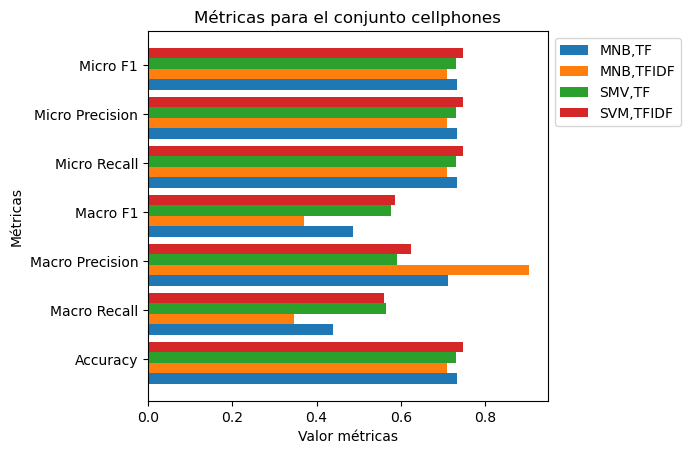

En la gráfica anterior se observan las métricas para el conjunto cellphones. Se nota que el modelo con mejor precisión es Naive Bayes con TF-IDF, sin embargo es el modelo con menor recall macro, lo que indica que no identifica correctamente las instancias de cada clase. Por ende, su $F_{1}$ también es el más bajo. 
Por otra parte, los modelos SVM con TF-IDF o TF tienen los valores más altos de exactitud y recall, por lo que podemos considerar que identifican correctamente las instancias de cada clase y predicen correctamente clases de las mismas. Por lo tanto, son mejores para este conjunto de datos.

#### Conjunto de agresividad

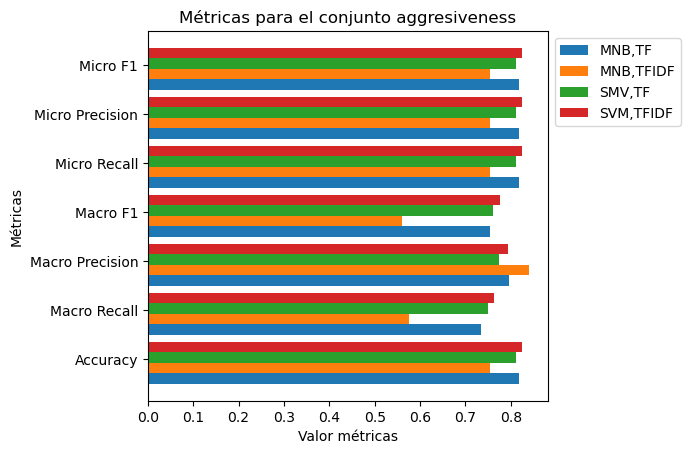

En la gráfica anterior, se encuentran las métricas para el conjunto de agresividad. Se puede observar que el modelo con mejor exactitud es SVM con TF-IDF, seguido de cerca por Naive Bayes con TF y SVM con TF. En cuestión de precisión macro, el modelo con mejor precisión es Naive Bayes con TF-IDF, sin embargo, posee los peores valores de recall y $F_{1}$ comparado con los demás. Con base en lo anteriormente expuesto, los mejores modelos para este conjunto son SVM (ambas versiones) y Naive Bayes con TF.

Finalmente, debe recordarse queaún pueden aplicarse técnicas para mejorar el desempeño de los algoritmos, como refinar el preprocesamiento del texto, optimización de los hiperparámetros de los algoritmos o técnicas para lidiar con el desbalance de clases.

# Conclusiones

La clasificación es una tarea fundamental en el procesamiento de lenguaje natural y el aprendizaje automático; sus aplicaciones y potencial son inmensas ya que permite el desarrollo de modelos predictivos, facilita el reconocimiento de patrones en texto y sirve como bloque de construcción para sistemas que ayuden a la toma de decisiones y proporcionen herramientas para recuperar, organizar y obtener conocimiento a partir de la vasta información textual que existe.

Por otra parte, la evaluación de los modelos de aprendizaje automático es crucial, pues no sólo permite conocer la calidad de las predicciones de un modelo, sino también da una pauta para comparar modelos entre sí, ayuda al proceso de desarrollo, (por ejemplo, al optimizar los hiperparámetros, saber si hay sobreajuste o subajuste, o identificar problemas como desbalance de clases) y, además,  permite tomar decisiones informadas sobre qué modelo es el mejor para una tarea.  

Finalmente, debe mencionarse que continuará siendo un área importante de cara al futuro, pues al seguir aumentando la información, será necesario contar con sistemas automáticos que permitan sacar el mayor provecho de ésta y aún más el contar con métodos que provean formas de evaluarlos.